#### Code used to construct the Hovmollers in Fig 13. I essentially load in the data, find the anomalies, and plot the figures.

In [13]:
import warnings
import netCDF4
import cmocean.cm as cm
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xmovie import Movie
import matplotlib.path as mpath
import numpy as np
import xarray as xr


from dask.distributed import Client
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import cosima_cookbook as cc


warnings.filterwarnings("ignore") # Suppress warnings for these docs

In [14]:
# Load workers:
client = Client(threads_per_worker = 1)
client

<Client: 'tcp://127.0.0.1:46195' processes=28 threads=28, memory=125.19 GiB>

## Temperature in Z-Coordinate

In [15]:
import cosima_cookbook as cc
db = 'local_cc_scratch_Ryan_data.db'
session = cc.database.create_session(db)
experiment = '025deg_jra55_iaf_cycle6_online_mlt'

In [16]:
import cosima_cookbook as cc
temp = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='temp', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-12-31 00:00:00')

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "yt_ocean" starting at index 108. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "xt_ocean" starting at index 120. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.12

In [17]:
temp_depth = temp - 273.15
temp_depth = temp_depth.isel(st_ocean = slice(0,50)).\
                        sel(time = slice('1981','2024'))## Restrict to Southern Ocean
print(temp_depth)

<xarray.DataArray 'temp' (time: 516, st_ocean: 50, yt_ocean: 1080,
                          xt_ocean: 1440)> Size: 160GB
dask.array<getitem, shape=(516, 50, 1080, 1440), dtype=float32, chunksize=(1, 25, 108, 120), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 4kB 1981-01-14T12:00:00 ... 2023-12-14T12...
  * st_ocean  (st_ocean) float64 400B 1.152 3.649 6.565 ... 5.034e+03 5.254e+03


In [18]:
import cosima_cookbook as cc
mld = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-12-31 00:00:00')

In [19]:
import cosima_cookbook as cc
dens = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='pot_rho_0', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-12-31 00:00:00')

In [20]:
def calculate_temp_anomaly(data, apply_rolling=False, rolling_window=1):
    """
    Calculates monthly temperature anomalies based on a 30-year climatology.
    Optionally applies a rolling mean smoothing to the climatology.
    
    Parameters:
        data (xarray.DataArray): Input temperature data with dimensions (time, st_ocean, lat, lon)
        apply_rolling (bool): Whether to apply rolling mean to the climatology
        rolling_window (int): Window size for rolling mean (applied along month dimension)

    Returns:
        climatology (xarray.DataArray): Monthly climatology (optionally smoothed)
        anomalies (xarray.DataArray): Monthly temperature anomalies
    """
    # 1. Select baseline period
    baseline_period = data.sel(time=slice("1982-01-01", "2011-12-31"))

    # 2. Compute monthly climatology (preserving st_ocean, lat, lon)
    clim_data = baseline_period.groupby("time.month").mean("time", keep_attrs=True)

    # 3. Optional rolling smoothing over the 12-month climatology
    if apply_rolling:
        clim_data = clim_data.rolling(month=rolling_window, center=True, min_periods=1).mean()

    # 4. Compute anomalies by subtracting monthly climatology
    anomalies = data.groupby("time.month") - clim_data

    return clim_data, anomalies

___, temp_anomalies = calculate_temp_anomaly(temp_depth)
___, dens_anomalies = calculate_temp_anomaly(dens)


In [21]:
import cosima_cookbook as cc
salt = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='salt', 
                          session=session, frequency='1 monthly',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-12-31 00:00:00')

import cosima_cookbook as cc
mld_salinity = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='salt_in_mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-12-31 00:00:00')

mld_temp = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='temp_in_mld', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-12-31 00:00:00')

sst = cc.querying.getvar(expt='025deg_jra55_iaf_cycle6_online_mlt', variable='sst', 
                          session=session, frequency='1 daily',
                          attrs={'cell_methods': 'time: mean'},
                          start_time='1957-12-31 00:00:00', 
                          end_time='2023-12-31 00:00:00')

## Fig. 13

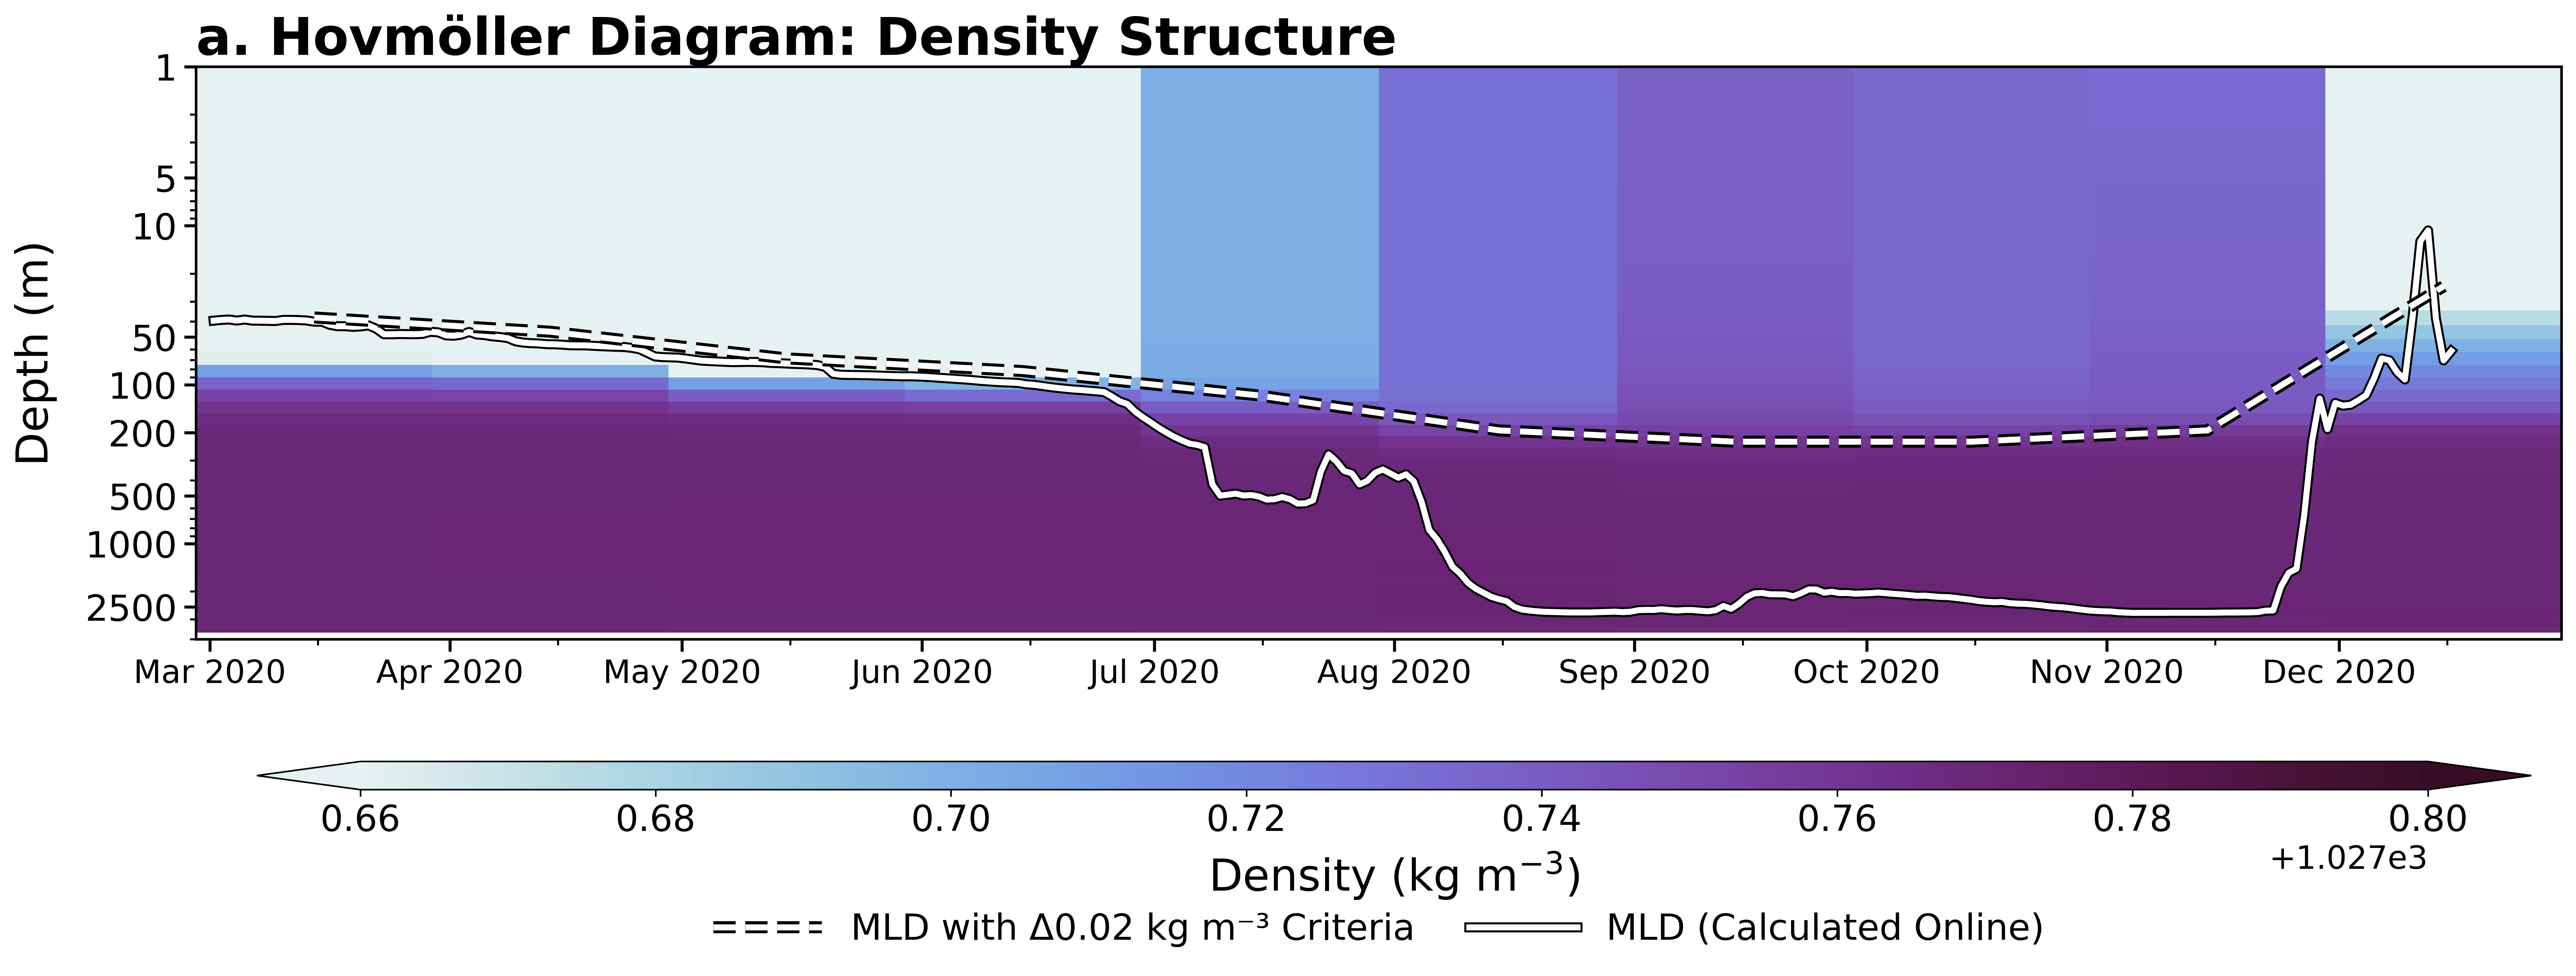

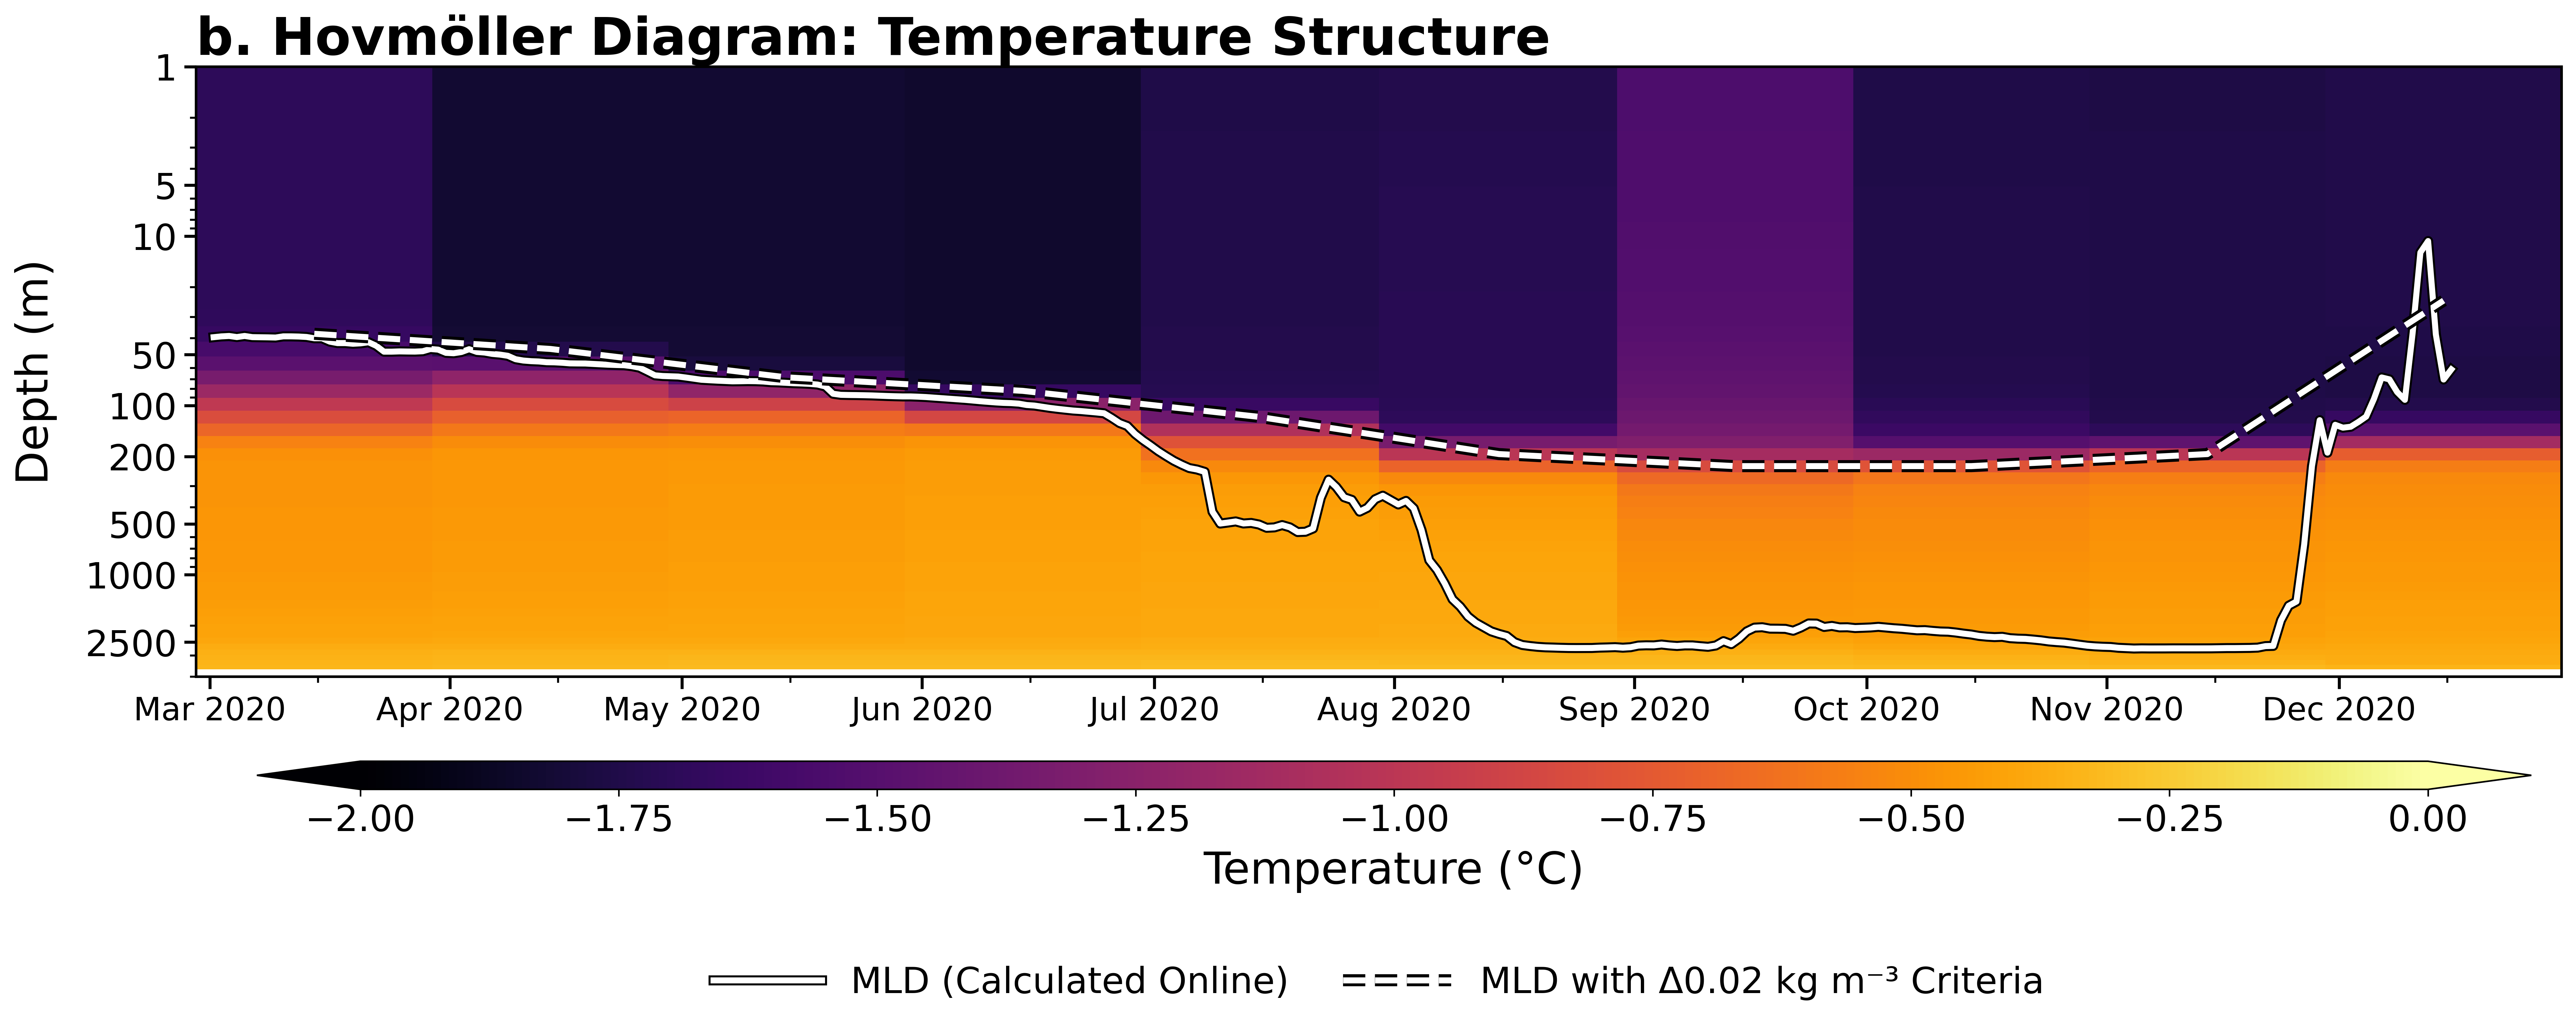

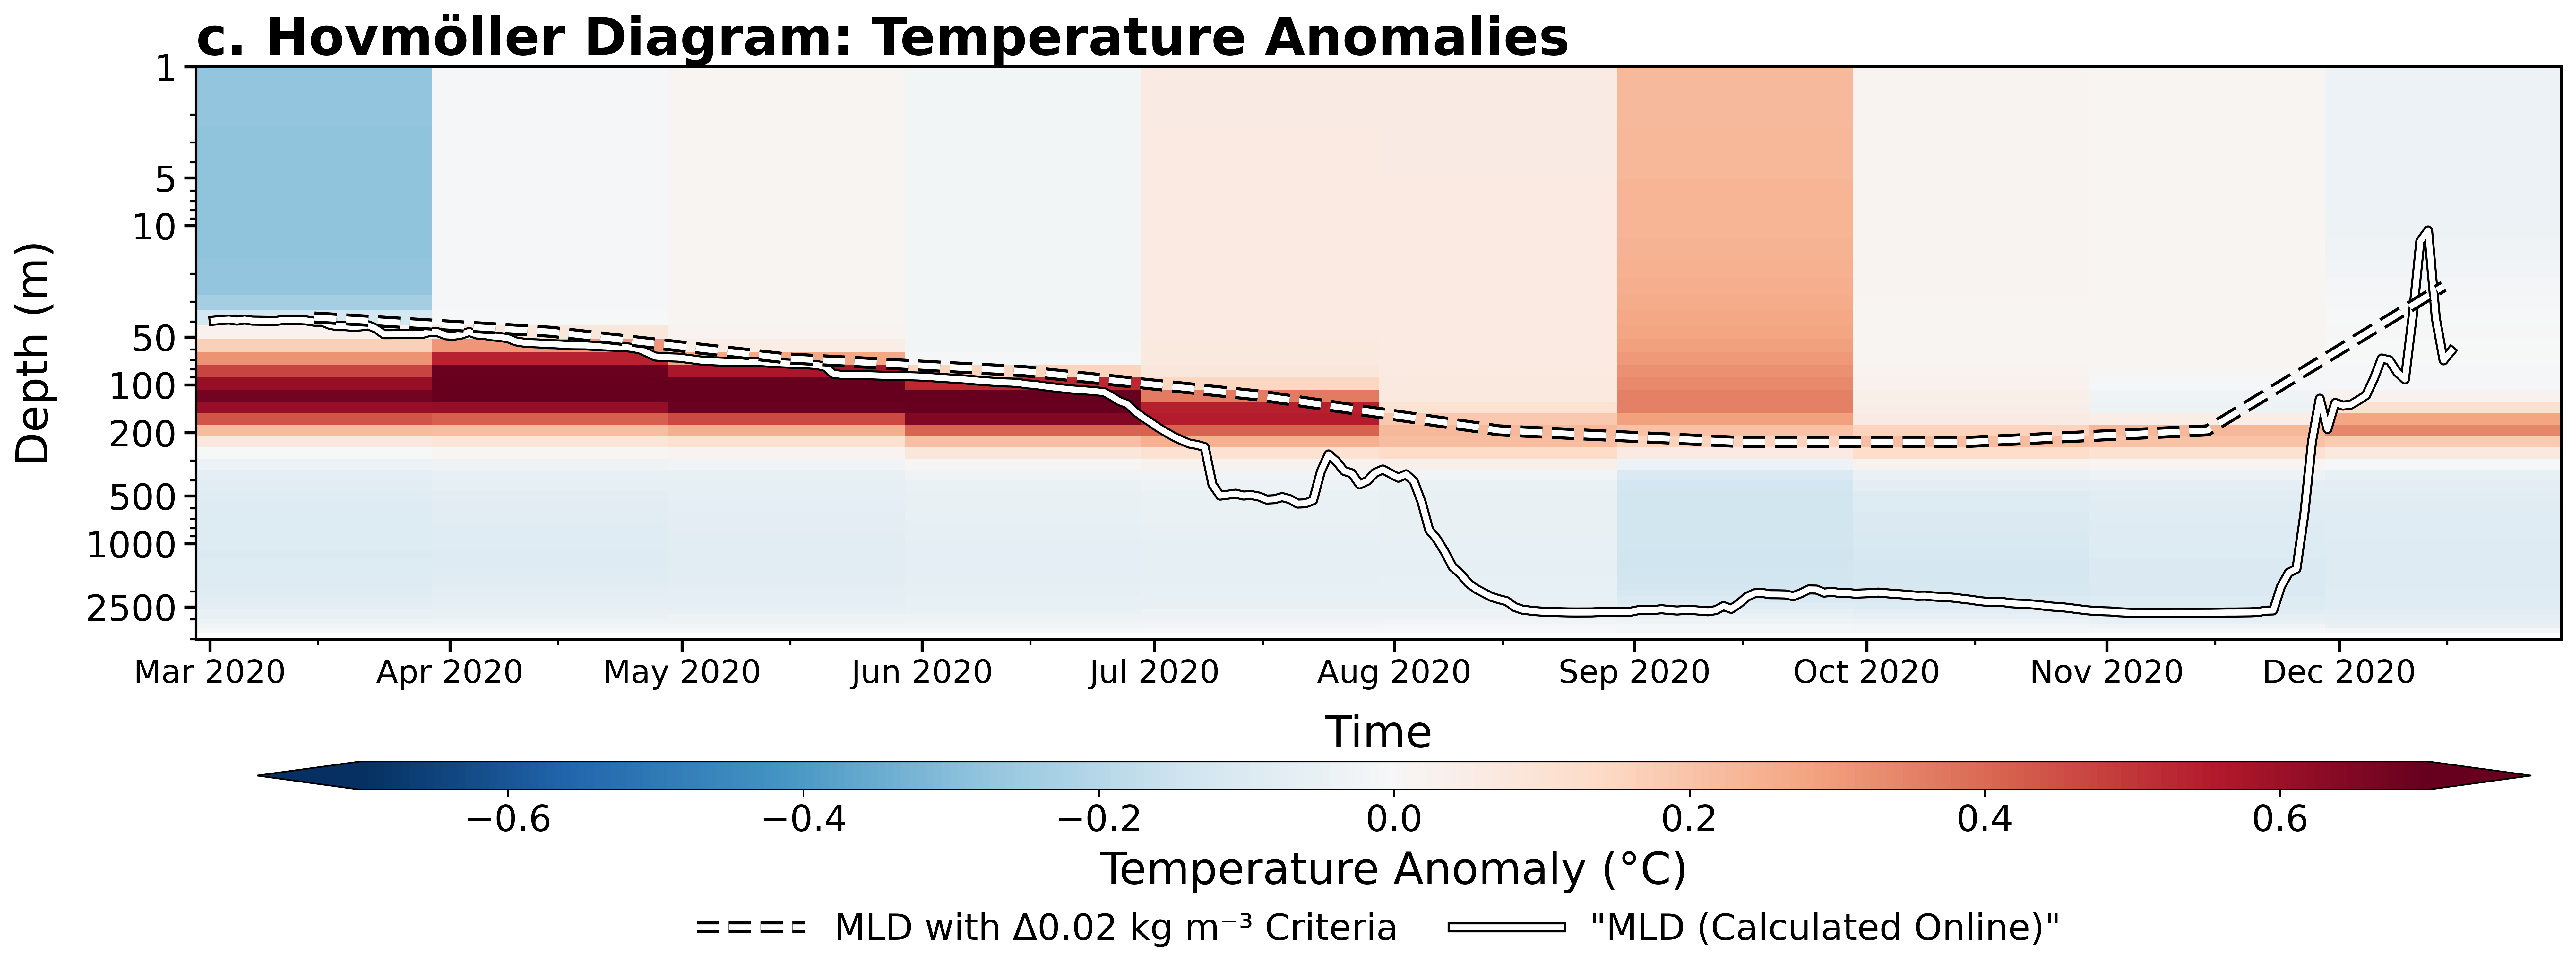

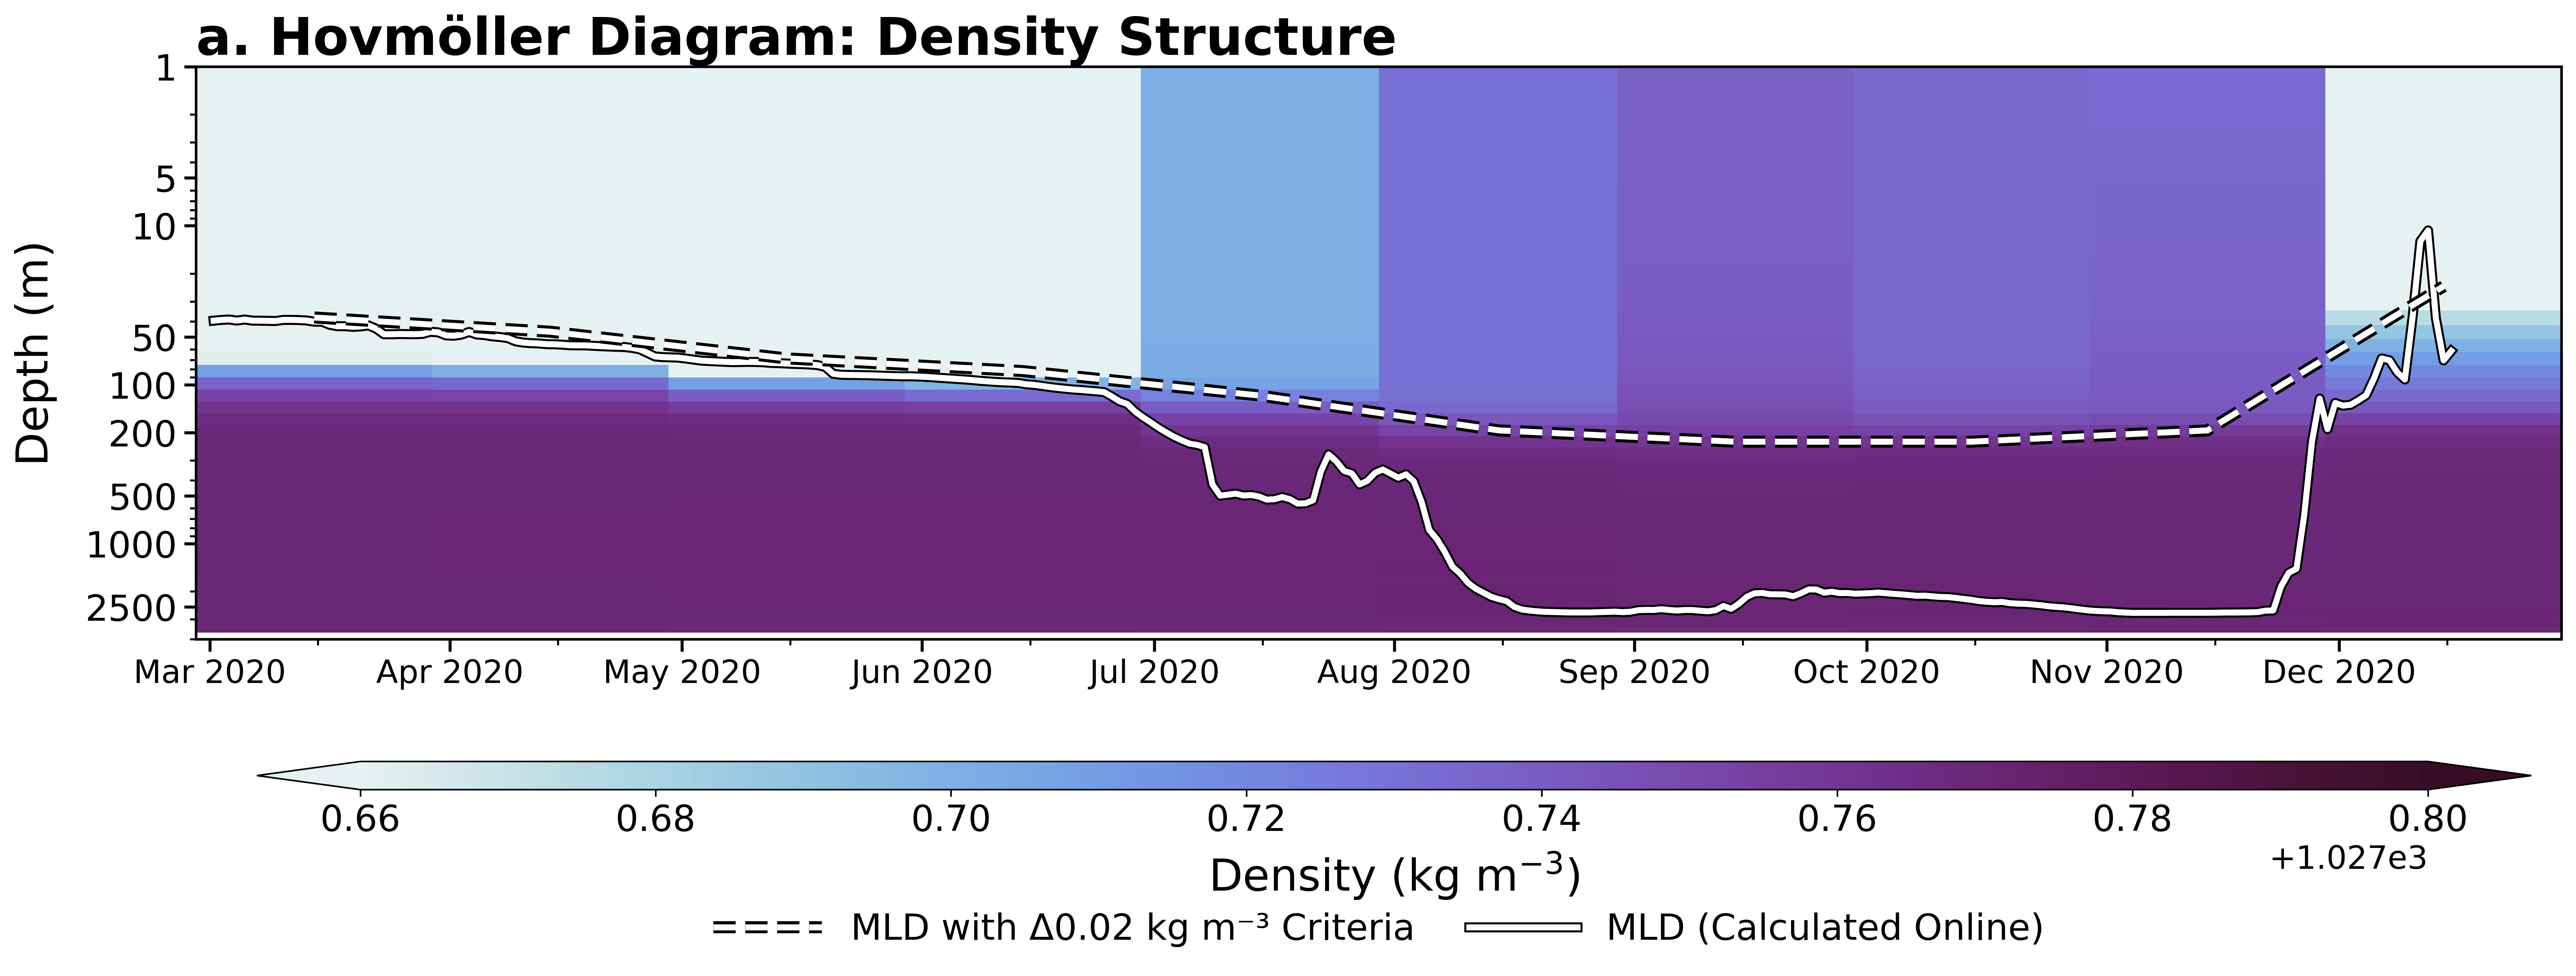

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
import cmocean
%matplotlib inline

# --- User input ---
xt_slice = slice(-190, -185)
yt_slice = slice(-71, -68)
time_slice = slice('2020-03-01', '2020-12-15')

# --- Data selection ---
def select_mean(data):
    return data.sel(time=time_slice).sel(xt_ocean=xt_slice).sel(yt_ocean=yt_slice).mean(dim=["yt_ocean", "xt_ocean"])

density_avg = select_mean(dens)
mld_select = select_mean(mld)

# --- Ensure consistent orientation (depth × time) ---
dens_values = density_avg.transpose("st_ocean", "time").values
depth = density_avg["st_ocean"].values
time_vals = density_avg["time"].values

# --- Compute Δ0.02 kg/m^3 surface density line ---
surface_dens = dens_values[0, :]
delta_dens = surface_dens + 0.02
depth_delta = np.full(surface_dens.shape, np.nan)
for t in range(dens_values.shape[1]):
    col = dens_values[:, t]
    mask = col >= delta_dens[t]
    if np.any(mask):
        depth_delta[t] = depth[mask][0]

# --- Figure setup ---
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.labelsize': 22,
    'axes.titlesize': 26,
    'xtick.labelsize': 16,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

fig, ax = plt.subplots(figsize=(21, 6.5), dpi=450)
fig.subplots_adjust(bottom=0.32, top=0.93, right=0.86, left=0.08)

# --- Density pcolormesh ---
c = ax.pcolormesh(
    time_vals,
    depth,
    dens_values,
    cmap=cmocean.cm.dense,
    shading="auto",
    vmin = 1027.66,
    vmax = 1027.80
)

# --- Δ0.02 line --- Applying this to the monthly averaged density data!
import matplotlib.patheffects as pe

ax.plot(
    density_avg['time'],
    depth_delta,
    color='white',       # main line color
    lw=3,                # width of the white line
    ls='--',             # dashed line
    label='MLD with Δ0.02 kg m⁻³ Criteria',
    path_effects=[
        pe.Stroke(linewidth=6, foreground='black'),  # black outline around entire line
        pe.Normal()                                  # draw the white line on top
    ],
    zorder=12
)

# --- MLD line ---
ax.plot(
    mld_select["time"],
    mld_select,
    color="white",
    lw=3,
    path_effects=[pe.Stroke(linewidth=5, foreground="black"), pe.Normal()],
    label="MLD (Calculated Online)",
    zorder=10
)

# --- Depth axis (log scale) ---
ax.set_yscale("log")
ax.invert_yaxis()
ax.set_ylim(4000, 1)
y_ticks = [1, 5, 10, 50, 100, 200, 500, 1000, 2500]
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='y', which='major', length=6, width=1.5)
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0)*0.1, numticks=10))
ax.tick_params(axis='y', which='minor', length=3, width=1)
ax.set_ylabel("Depth (m)", fontsize=22, labelpad=14)

# --- X-axis formatting (month + year) ---
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.tick_params(axis='x', which='major', length=6, width=1.5)
ax.tick_params(axis='x', which='minor', length=3, width=1)
plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
ax.set_xlabel("")  # remove x-axis label

# --- Title ---
ax.set_title("a. Hovmöller Diagram: Density Structure", fontsize=26, weight="bold", loc="left")

# --- Colorbar (lowered) with extend triangles ---
cbar_ax = fig.add_axes([0.1, 0.16, 0.75, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(c, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label("Density (kg m$^{-3}$)", fontsize=22, labelpad=6)
cbar.ax.tick_params(labelsize=18)

# --- Legend below colorbar ---
lns, labs = ax.get_legend_handles_labels()
ax.legend(
    lns,
    labs,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.42),
    ncol=3,
    frameon=False,
    columnspacing=1.5,
    handlelength=3.0
)

# --- Clean aesthetics ---
for spine in ax.spines.values():
    spine.set_linewidth(1.3)
ax.grid(False)

fig.savefig("/g/data/e14/ts7341/wind/hov/density_structure.png", dpi=400, bbox_inches='tight')

plt.show()

## Code to produce individual Hovmoller figures

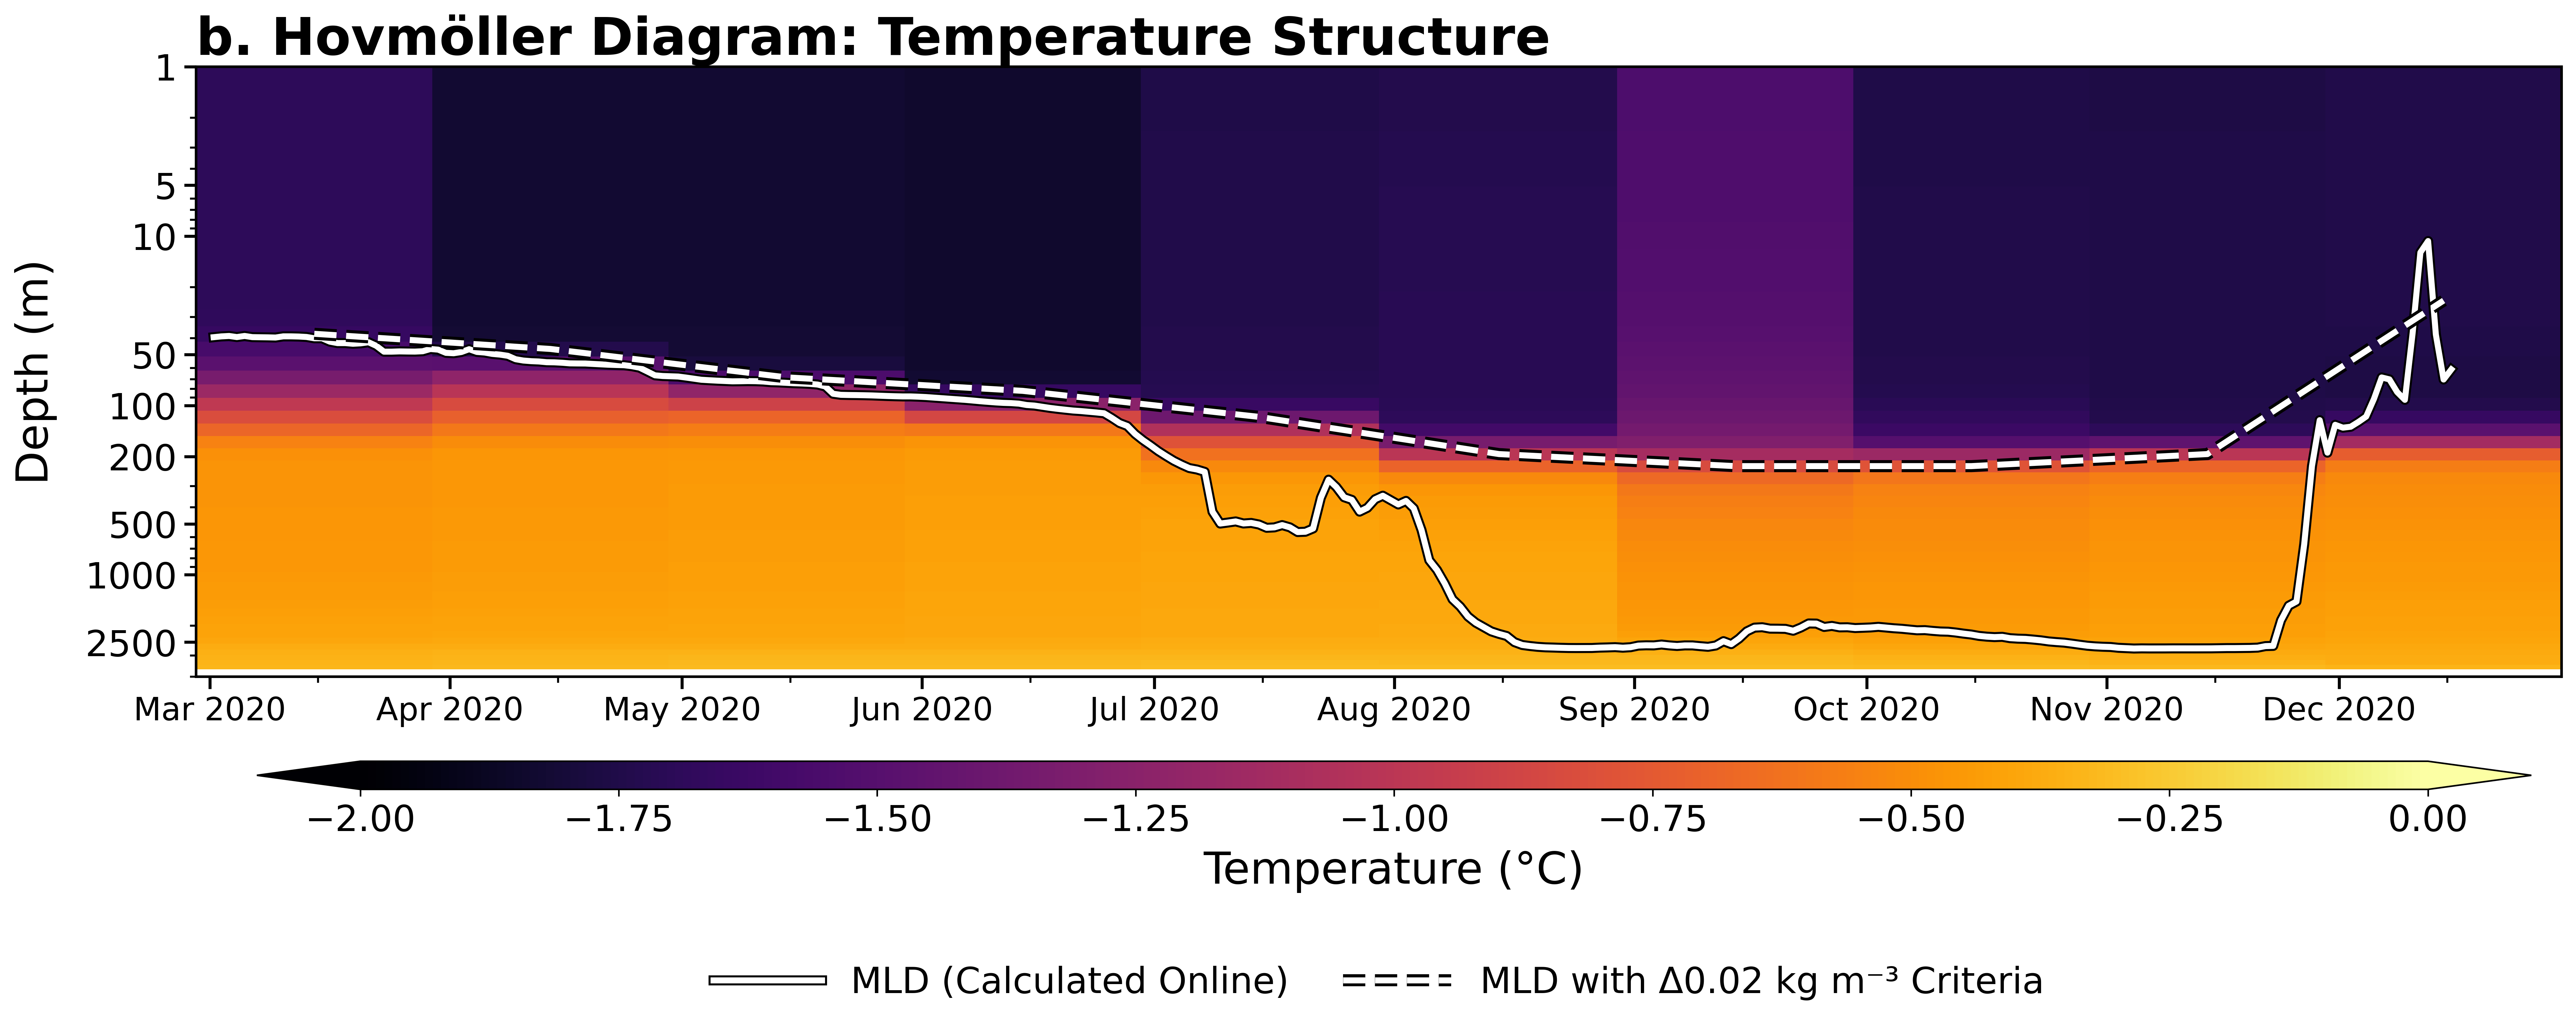

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
import matplotlib.cm as cm
from matplotlib.patches import Polygon

# --- User input ---
xt_slice = slice(-190, -185)
yt_slice = slice(-71, -68)
time_slice = slice('2020-03-01', '2020-12-15')

# --- Data selection ---
def select_mean(data):
    return data.sel(time=time_slice).sel(xt_ocean=xt_slice).sel(yt_ocean=yt_slice).mean(dim=["yt_ocean", "xt_ocean"])

mld_select = select_mean(mld)
temp_avg = select_mean(temp_depth)
mld_temp_select = select_mean(mld_temp) / 1035
sst_plot = select_mean(sst) - 273.15

# --- Grid ---
depth = temp_avg['st_ocean'].values
time_vals = temp_avg['time'].values
time_grid, depth_grid = np.meshgrid(time_vals, depth)

# --- Figure setup ---
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.labelsize': 22,
    'axes.titlesize': 26,
    'xtick.labelsize': 16,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

fig, ax = plt.subplots(figsize=(21, 6.5), dpi=450)
fig.subplots_adjust(bottom=0.28, top=0.93, right=0.86, left=0.08)

# --- Temperature field ---
c = ax.pcolormesh(
    time_grid,
    depth_grid,
    temp_avg.values.T,
    cmap=cm.inferno,
    shading="auto",
    vmin=-2,
    vmax=0,
)

# --- MLD line ---
ax.plot(
    mld_select["time"],
    mld_select,
    color="white",
    lw=3,
    path_effects=[pe.Stroke(linewidth=5, foreground="black"), pe.Normal()],
    label="MLD (Calculated Online)",
    zorder=10,
)

# --- Δ0.02 line ---
import matplotlib.patheffects as pe

ax.plot(
    density_avg['time'],
    depth_delta,
    color='white',       # main line color
    lw=3,                # width of the white line
    ls='--',             # dashed line
    label='MLD with Δ0.02 kg m⁻³ Criteria',
    path_effects=[
        pe.Stroke(linewidth=6, foreground='black'),  # black outline around entire line
        pe.Normal()                                  # draw the white line on top
    ],
    zorder=12
)

# --- Depth axis (log scale) ---
ax.set_yscale("log")
ax.invert_yaxis()
ax.set_ylim(4000, 1)
y_ticks = [1, 5, 10, 50, 100, 200, 500, 1000, 2500]
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.tick_params(axis='y', which='major', length=6, width=1.5)
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0)*0.1, numticks=10))
ax.tick_params(axis='y', which='minor', length=3, width=1)
ax.set_ylabel("Depth (m)", fontsize=22, labelpad=14)

# --- X-axis formatting (align ticks to month edges) ---
month_edges = mdates.MonthLocator()
ax.xaxis.set_major_locator(month_edges)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))

# Minor ticks at mid-month
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.tick_params(axis='x', which='major', length=6, width=1.5)
ax.tick_params(axis='x', which='minor', length=3, width=1)
plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)
ax.set_xlabel("")  # remove x-axis label

# --- Title ---
ax.set_title("b. Hovmöller Diagram: Temperature Structure", fontsize=26, weight="bold", loc="left")

# --- Colorbar (lowered) with extend triangles ---
cbar_ax = fig.add_axes([0.1, 0.16, 0.75, 0.03])  # [left, bottom, width, height]
cbar = fig.colorbar(c, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label("Temperature (°C)", fontsize=22, labelpad=6)
cbar.ax.tick_params(labelsize=18)


# --- Legend below colorbar ---
lns1, labs1 = ax.get_legend_handles_labels()
ax.legend(
    lns1, #+ lns2,
    labs1,# + labs2,
    loc="upper center",
    bbox_to_anchor=(0.5, -0.42),
    ncol=3,
    frameon=False,
    columnspacing=1.5,
    handlelength=3.0
)

# --- Clean aesthetics ---
for spine in ax.spines.values():
    spine.set_linewidth(1.3)
ax.grid(False)

fig.savefig("/g/data/e14/ts7341/wind/hov/temperature_structure.png", dpi=400, bbox_inches='tight')

plt.show()


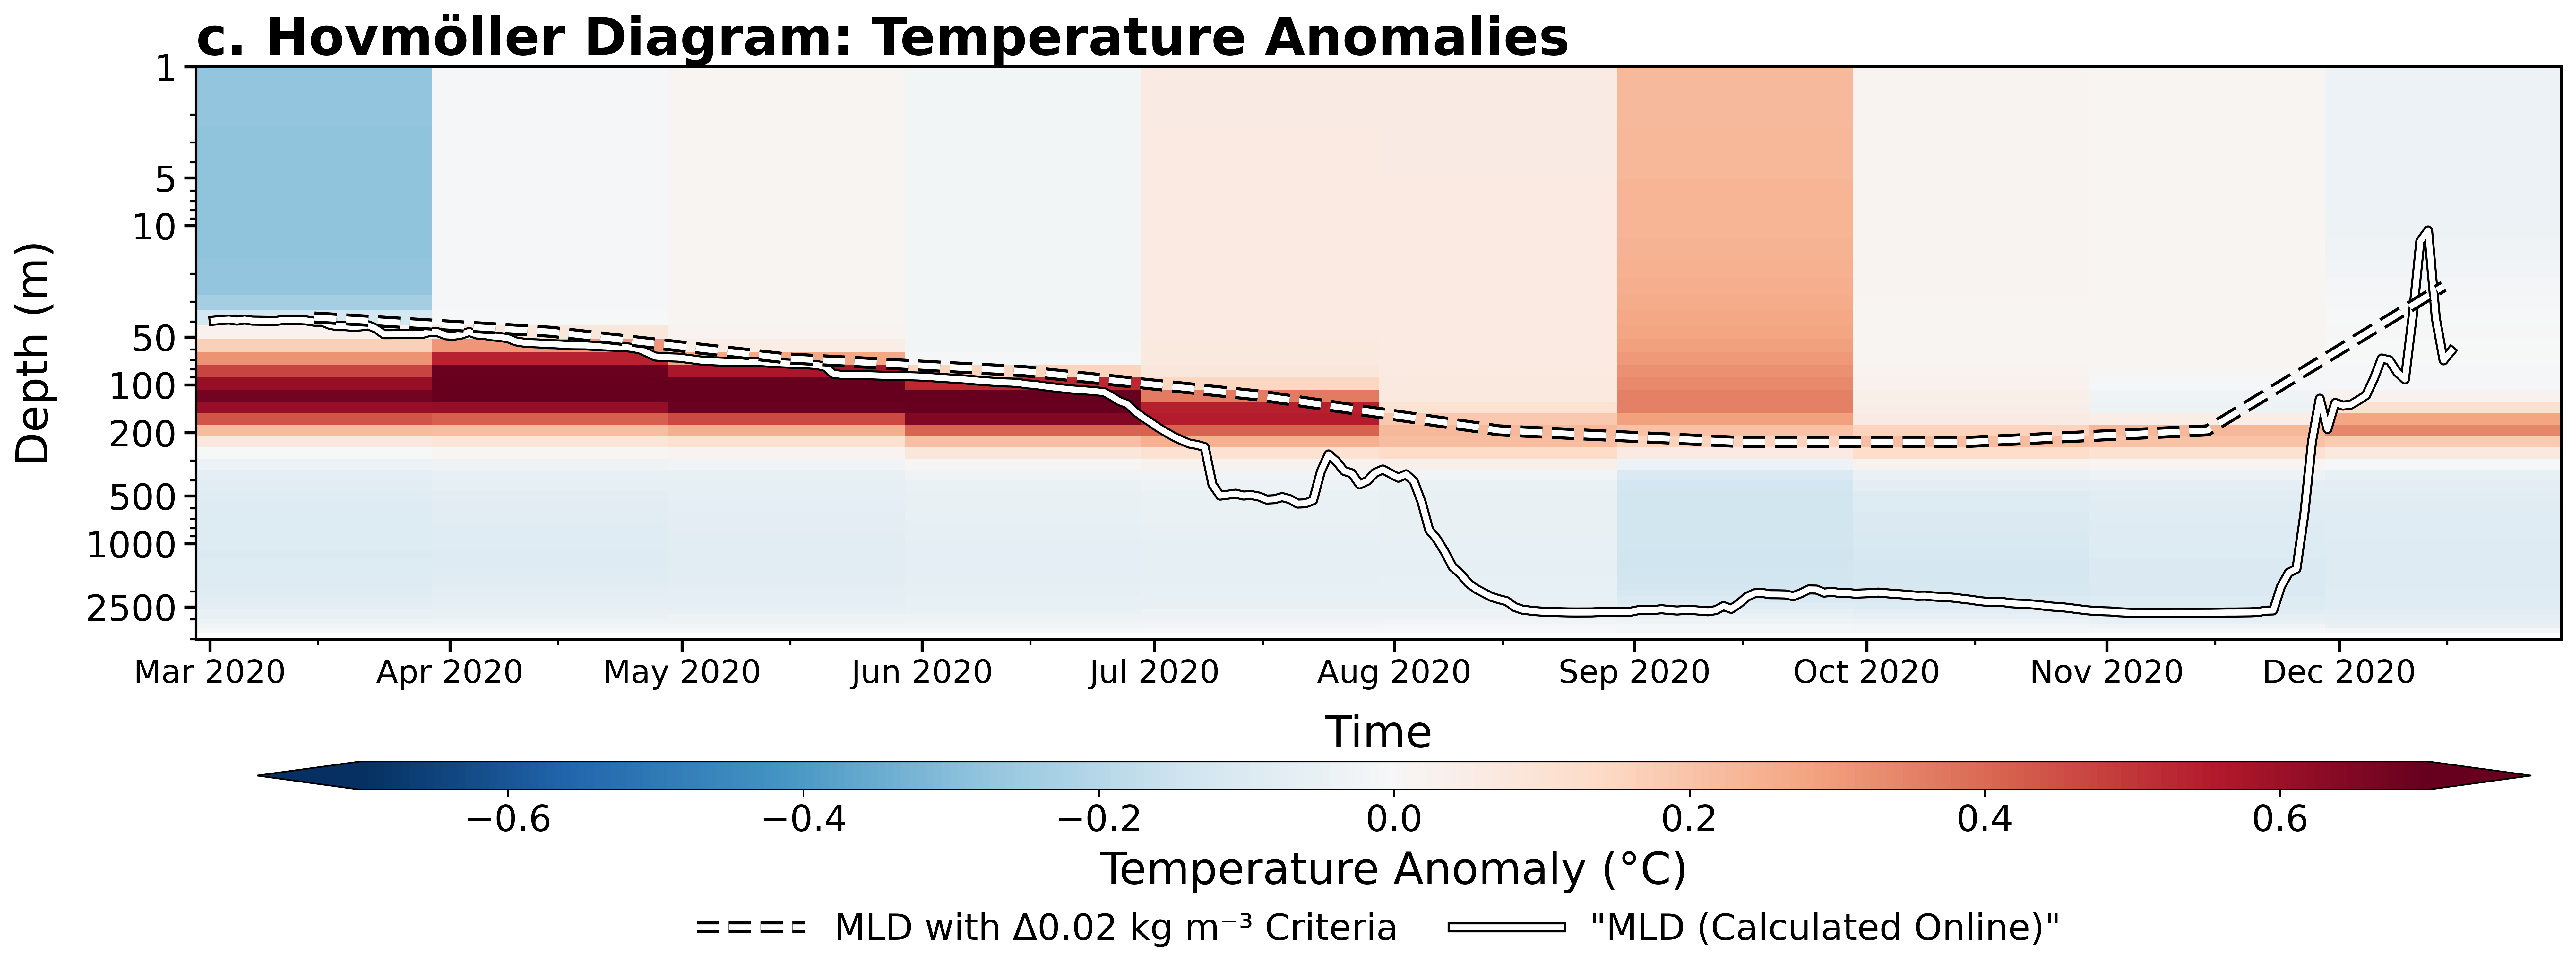

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
import matplotlib.dates as mdates

# --- User input ---
xt_slice = slice(-190, -185)
yt_slice = slice(-71, -68)
time_slice = slice('2020-03-01','2020-12-15')

# --- Data selection ---
def select_mean(data):
    return data.sel(time=time_slice).sel(xt_ocean=xt_slice).sel(yt_ocean=yt_slice).mean(dim=["yt_ocean", "xt_ocean"])

mld_select = select_mean(mld)
density_avg = select_mean(dens)
temp_anom = select_mean(temp_anomalies)

# --- Grid for temperature anomaly ---
depth_temp = temp_anom['st_ocean'].values
time_vals_temp = temp_anom['time'].values
time_grid_temp, depth_grid_temp = np.meshgrid(time_vals_temp, depth_temp)

# --- Δ0.02 density (from density data) ---
dens_values = density_avg.transpose("st_ocean","time").values
delta_dens = dens_values[0,:] + 0.02
depth_delta = np.full(delta_dens.shape, np.nan)
for t in range(dens_values.shape[1]):
    col = dens_values[:, t]
    mask = col >= delta_dens[t]
    if np.any(mask):
        depth_delta[t] = density_avg['st_ocean'].values[mask][0]

# --- Figure setup ---
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'axes.labelsize': 22,
    'axes.titlesize': 26,
    'xtick.labelsize': 16,
    'ytick.labelsize': 18,
    'legend.fontsize': 18
})

fig, ax = plt.subplots(figsize=(21,6.5), dpi=450)
fig.subplots_adjust(bottom=0.32, top=0.93, right=0.86, left=0.08)

# --- Temperature anomaly field ---
c = ax.pcolormesh(
    time_grid_temp,
    depth_grid_temp,
    temp_anom.values.T,
    cmap='RdBu_r',
    shading='auto',
    vmin=-0.7,
    vmax=0.7
)

# --- Δ0.02 density line overlay (white dashed with black outline) ---
ax.plot(
    density_avg['time'],
    depth_delta,
    color='white',       # main line color
    lw=3,                # width of the white line
    ls='--',             # dashed line
    label='MLD with Δ0.02 kg m⁻³ Criteria',
    path_effects=[
        pe.Stroke(linewidth=6, foreground='black'),  # black outline all around
        pe.Normal()
    ],
    zorder=12
)

# --- MLD line ---
ax.plot(
    mld_select['time'],
    mld_select,
    color='white',
    lw=3,
    path_effects=[pe.Stroke(linewidth=5, foreground='black'), pe.Normal()],
    label='"MLD (Calculated Online)"',
    zorder=10
)

# --- Depth axis (log scale) ---
ax.set_yscale('log')
ax.invert_yaxis()
ax.set_ylim(4000,1)
y_ticks = [1,5,10,50,100,200,500,1000,2500]
ax.set_yticks(y_ticks)
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1.0,10.0)*0.1))
ax.tick_params(axis='y', which='major', length=6, width=1.5)
ax.tick_params(axis='y', which='minor', length=3, width=1)
ax.set_ylabel("Depth (m)", fontsize=22, labelpad=14)

# --- X-axis formatting ---
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=15))
ax.tick_params(axis='x', which='major', length=6, width=1.5)
ax.tick_params(axis='x', which='minor', length=3, width=1)
plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontsize=16)

# --- Add time label ---
ax.set_xlabel("Time", fontsize=22, labelpad=12)

# --- Title ---
ax.set_title("c. Hovmöller Diagram: Temperature Anomalies", fontsize=26, weight='bold', loc='left')

# --- Colorbar below plot with extend triangles ---
cbar_ax = fig.add_axes([0.1, 0.16, 0.75, 0.03])
cbar = fig.colorbar(c, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label("Temperature Anomaly (°C)", fontsize=22, labelpad=6)
cbar.ax.tick_params(labelsize=18)

# --- Legend below colorbar ---
lns, labs = ax.get_legend_handles_labels()
ax.legend(
    lns,
    labs,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.42),
    ncol=2,
    frameon=False,
    columnspacing=1.5,
    handlelength=3.0
)

# --- Clean aesthetics ---
for spine in ax.spines.values():
    spine.set_linewidth(1.3)
ax.grid(False)

# --- Save figure ---
fig.savefig("/g/data/e14/ts7341/wind/hov/temperature_anomaly.png", dpi=400, bbox_inches='tight')

plt.show()
